# FINAL PROYECT: MONTEVIDEO TRANSIT OVERSPEED INQUIRY

##  CASE OF STUDY

A transit prevention company is keen on realizing a project of transit security improvement as to show it's potencial to new customers. Due to the high level of exposition this project has, they have to ensure to make the highes outcome possible.
As the project consists in educating and preventin car accidents and ensuring they respect the speed limits, a study of this matter must be made.
The company is settled in Uruguay and wants to approach the capital municipality, the city of Montevideo.
The company must choose the spot in Montevideo with highest rate of overspeeds.

## USEFUL DATA

The data needing for this data analysis is the following:
- Montevideo city areas geographic coordinates. This is found in the Open Data Catalog from the Data and Stadistics window of the Uruguayan gubernment site: https://catalogodatos.gub.uy/dataset?tags=movilidad&organization=intendencia-montevideo. This also has the information of the postal code of each area needed for registering the validation of the project.
- Montevideo city geographic localization of the car speed sensoring devices throughout the city. This file also provides the registry of velocity measurements for the hole month of December 2021. This file was extracted through the same site: https://catalogodatos.gub.uy/dataset?tags=movilidad&organization=intendencia-montevideo
- We will also need the localization of each neighborhood. The area coordinates are not specific enought and we will need the respective neighborhood to target. This data was found in the Geographic Computer System: https://sig.montevideo.gub.uy/. The data was downloaded as a DBF file and converted to CSV open UTF8 format file.
- Geographic coordinates of streets of Montevideo city found in Foursquare site as a developer user API requester:  https://es.foursquare.com/developers/projects

## METHODOLOGY WALKTHROUGH

- Montevideo area coordenates:
After importing the csv file downloaded we must clean the data. Only the columns Latitude, Longitude, Postal code and City must remain. Geographic coordinates must be shorten and all data without decimals must be transformed to integer. This is to simplify the view. Also change colum names for all upper case and easy names. All strings changed also to upper.


- Velocity and localization data:
This is the most abundant information. The same changes must be done to data as last file. The important data is: Latitude and Longitude of sensor, street where it is at and the hour of the record.
The can be NaN of cero values that must be withdrawn. 
Categorize the hours into 4 categories depending on the range of the day (night, morning, afternoon, etc). This will be useful for futher analysis and sensitivity study of the hours and the speeds. 
Data must be grouped.
The registers of the same spot must be grouped as to shorten the dataframe and the corresponding velocity values must be substituted by the mean and quantity of values used for that mean calculation.
This dataframe is the most important. It should me extracted the top critical areas depending on the over speeding and the quantify of cars that do so. Two diferent analysis will be made. Analyze this data.


- Neighbourhood geographic information:
We must categorize each measurements of sensors by the neighbourhood to which they correspond. When we have the final conclution of taget area to asses, the neighbourhood must be known. It is also usefull to show in map.
The dataset has no information of the coordinates of the neighbourhoods. Nevertheless, it has the distance to the 0 km spot located in the monument Obelisto located in Plaza Cagancha, Centro.
As to cross reference the latitude and longitude of places to theirs neighbourhoods, the distances between measurement points and areas and the 0 km location must be calculated. This way the crossreference can me done with a certain amount of flexibility and aproximation.


- Visualization:
Measurement points will be displayed in the map. Also the top 10 places where top overspeeds are achieved and the top quantity of cars.
Clustering will be make to classify critical areas and find an external explanation.
algo a linear plot of all the means velocity over speed measurements will be ploted in reference to the distance of the 0km. This is to detect a stong anomally in certain point.
Afterwards, histograms of all de velocities, clasified in the range of hours in which the day was categorized, will be plotted. This is to detect in which hour is best to approach the issue of the project. It could be that the time of the day induces another way of driving.

## Data Analysis 

### Import needed libraries

In [496]:
import numpy as np
import pandas as pd
import json  
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
from math import sin, cos, sqrt, atan2, radians
import matplotlib.pyplot as plt

## Import Montevideo city geographic coordinates and postal codes dataset

In [497]:
mdeo_coords = pd.read_csv("montevideo.csv")
mdeo_coords

,latitud,longitud,punto_wkb,codigo_postal,codigo_via,nombre_via,num_puerta,letra_puerta,km,manzana,solar,nombre_inmueble,localidad,codigo_localidad,departamento
0,-34.77,-56.22,0101000020D17F0000CA505C70926E21419249DD540678...,12400,"42,375.00",ABREVADERO,220.00,NaN,nan,nan,nan,NaN,ABAYUBA,"3,208.00",MONTEVIDEO
1,-34.77,-56.22,0101000020D17F0000666666E6C26F2141CDCCCCBCBA77...,12400,"13,795.00",ABREVADERO,"5,410.00",NaN,nan,nan,nan,NaN,ABAYUBA,"3,208.00",MONTEVIDEO
2,-34.77,-56.22,0101000020D17F00003D0AD7A3AD6F2141E17A145EBC77...,12400,"13,795.00",ABREVADERO,"5,420.00",NaN,nan,nan,nan,NaN,ABAYUBA,"3,208.00",MONTEVIDEO
3,-34.77,-56.22,0101000020D17F00003D0AD723976F21417B14AE17BE77...,12400,"13,795.00",ABREVADERO,"5,430.00",NaN,nan,nan,nan,NaN,ABAYUBA,"3,208.00",MONTEVIDEO
4,-34.77,-56.22,0101000020D17F00003D0AD723976F21417B14AE17BE77...,12400,"13,795.00",ABREVADERO,"5,440.00",NaN,nan,nan,nan,NaN,ABAYUBA,"3,208.00",MONTEVIDEO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411677,-30.43,-57.43,0101000020D17F00005E12BB8E76F91B41D364B6F1BE4D...,55100,nan,NaN,nan,NaN,nan,23.00,3.00,NaN,TOMAS GOMENSORO,111.00,ARTIGAS
411678,-34.73,-56.17,0101000020D17F00005780DD5E63962141C3FCCD28487C...,12400,"8,103.00",AVENIDA DON PEDRO DE MENDOZA,"8,610.00",NaN,nan,nan,nan,NaN,NaN,nan,MONTEVIDEO
411679,-34.73,-56.17,0101000020D17F00006E2E1FE8209621418A13EBE2327C...,12400,"8,103.00",AVENIDA DON PEDRO DE MENDOZA,"8,650.00",NaN,nan,nan,nan,NaN,NaN,nan,MONTEVIDEO
411680,-34.88,-56.25,0101000020D17F000048E17A14715B214114AE4701166C...,12800,"9,574.00",CHINA,"1,577.00",NaN,nan,nan,nan,NaN,NaN,nan,MONTEVIDEO


## Crean the data

- Drop columns that are not needed
- Erase information that does not correspond to the city of interest
- Change case of strigs and columns titles
- Chop decimal numbers of floating points
- Erase NaN and cero values
- Reorder columns due to its utility

In [498]:
vias = mdeo_coords
vias = vias.drop(['punto_wkb', 'codigo_via', 'nombre_via','num_puerta', 'letra_puerta', 'km', 'manzana', 'solar', 'nombre_inmueble', 'codigo_localidad'], axis=1)
vias.sort_values("localidad", inplace=True)
#vias.drop_duplicates(subset="nombre_via", keep='first', inplace=True)
vias = vias[vias['departamento']=="MONTEVIDEO"]
vias = vias.drop(['departamento'], axis=1)
vias.columns = ['lat', 'lon', 'pcode', 'ciudad']
vias.columns = [x.upper() for x in vias.columns]
vias = vias.astype({"LAT":str, "LON":str})
vias['LAT'] = vias['LAT'].str[:6]
vias['LON'] = vias['LON'].str[:6]
vias['LAT'] = vias['LAT'].astype(float)
vias['LON'] = vias['LON'].astype(float)
vias = vias.dropna(subset=['CIUDAD'])
vias

,LAT,LON,PCODE,CIUDAD
0,-34.76,-56.22,12400,ABAYUBA
1117,-34.76,-56.21,12400,ABAYUBA
1116,-34.76,-56.21,12400,ABAYUBA
1115,-34.76,-56.21,12400,ABAYUBA
1114,-34.76,-56.21,12400,ABAYUBA
...,...,...,...,...
410404,-34.75,-56.11,12400,TOLEDO CHICO
410403,-34.75,-56.11,13000,TOLEDO CHICO
410401,-34.75,-56.11,13000,TOLEDO CHICO
410408,-34.75,-56.11,13000,TOLEDO CHICO


## Extract dataset of velocity measurements for December 2021 in Montevideo

In [499]:
mdeo_vels = pd.read_csv("autoscope_12_2021_velocidad.csv")
mdeo_vels

,cod_detector,id_carril,fecha,hora,dsc_avenida,dsc_int_anterior,dsc_int_siguiente,latitud,longitud,velocidad
0,107,1,2021-12-01,23:55:00.0,Gral Flores,Carreras Nacionales,Corrales,-34.85,-56.15,45.00
1,206,1,2021-12-01,23:55:00.0,Arenal Grande,Mercedes,Colonia,-34.90,-56.17,82.00
2,104,1,2021-12-01,23:55:00.0,Evaristo Ciganda,Millan,Agraciada,-34.88,-56.20,30.00
3,107,1,2021-12-01,23:55:00.0,Garibaldi,Urquiza,8 de Octubre,-34.89,-56.16,27.00
4,215,3,2021-12-01,23:55:00.0,Bv Batlle y Ordonez,Joanico,8 de Octubre,-34.88,-56.15,27.00
...,...,...,...,...,...,...,...,...,...,...
4009779,119,121,2021-12-31,00:00:00.0,Solano Garcia,Bv Artigas,Ellauri,-34.92,-56.16,35.00
4009780,111,9,2021-12-31,00:00:00.0,Gral Flores,Carreras Nacionales,Corrales,-34.85,-56.15,0.00
4009781,107,9,2021-12-31,00:00:00.0,Garzon,Saravia,Casavalle,-34.81,-56.22,82.00
4009782,216,9,2021-12-31,00:00:00.0,Garzon,Casavalle,Saravia,-34.81,-56.22,41.00


## Clean the data

- Drop columns that are not needed
- Erase information that does not correspond to the city of interest
- Change case of strigs and columns titles
- Chop decimal numbers of floating points
- Erase NaN and cero values
- Reorder columns due to its utility
- Extract only the hour of the date columna
- Clasify the hour in 4 categories

In [500]:
vels = mdeo_vels.drop(['fecha','cod_detector','dsc_int_anterior', 'id_carril', 'dsc_int_siguiente'], axis=1)
vels.columns = ['time', 'street', 'lat', 'lon', 'velocity']
vels.columns = [x.upper() for x in vels.columns]
vels['STREET'] = vels['STREET'].str.lower()
vels = vels.astype({"LAT":str, "LON":str})
vels['TIME'] = vels['TIME'].str[:2]
vels['LAT'] = vels['LAT'].str[:6]
vels['LON'] = vels['LON'].str[:6]
vels['TIME'] = vels['TIME'].astype(int)
vels['LAT'] = vels['LAT'].astype(float)
vels['LON'] = vels['LON'].astype(float)
vels['VELOCITY'] = vels['VELOCITY'].astype(int)
vels['DAYTIME'] = pd.cut(vels['TIME'], bins=4, labels=('madrugada','mañana','tarde','noche'))
vels = vels.drop(['TIME'], axis=1)
vels = vels.iloc[:,[1,2,4,3,0]]
vels = vels[vels.VELOCITY != 0]
vels

,LAT,LON,DAYTIME,VELOCITY,STREET
0,-34.84,-56.15,noche,45,gral flores
1,-34.89,-56.17,noche,82,arenal grande
2,-34.87,-56.19,noche,30,evaristo ciganda
3,-34.88,-56.16,noche,27,garibaldi
4,-34.87,-56.14,noche,27,bv batlle y ordonez
...,...,...,...,...,...
4009777,-34.83,-56.22,madrugada,42,garzon
4009779,-34.92,-56.15,madrugada,35,solano garcia
4009781,-34.81,-56.22,madrugada,82,garzon
4009782,-34.81,-56.22,madrugada,41,garzon


In [501]:
vels_over = vels[vels['VELOCITY']>60]
vels_under = vels[vels['VELOCITY']<=60]

In [502]:
new_vels_over = vels_over.groupby(['LAT','LON'],as_index=False)['VELOCITY'].agg(['mean','count']).reset_index()
new_vels_over.columns = ['LAT','LON','MEAN_OVER','COUNT_OVER']
new_vels_over

,LAT,LON,MEAN_OVER,COUNT_OVER
0,-34.92,-56.16,69.84,247
1,-34.92,-56.15,79.55,1102
2,-34.91,-56.17,69.84,1346
3,-34.91,-56.16,76.49,18194
4,-34.91,-56.15,73.04,9574
...,...,...,...,...
57,-34.82,-56.22,69.82,144
58,-34.82,-56.21,65.91,66
59,-34.81,-56.22,74.16,732
60,-34.80,-56.22,71.72,18


In [503]:
top10counts_over = new_vels_over.nlargest(10,['COUNT_OVER'])
top10counts_over.round(decimals=2)
top10counts_over

,LAT,LON,MEAN_OVER,COUNT_OVER
3,-34.91,-56.16,76.49,18194
11,-34.90,-56.14,83.52,16099
23,-34.88,-56.18,71.60,12621
14,-34.89,-56.17,72.61,9778
4,-34.91,-56.15,73.04,9574
24,-34.88,-56.16,68.03,8882
19,-34.89,-56.11,70.94,7344
12,-34.90,-56.13,72.33,6834
9,-34.90,-56.16,71.79,6814
15,-34.89,-56.16,70.81,6090


In [504]:
statics_counts_over = top10counts_over.describe()
statics_counts_over.astype(int)

,LAT,LON,MEAN_OVER,COUNT_OVER
count,10,10,10,10
mean,-34,-56,73,10223
std,0,0,4,4146
min,-34,-56,68,6090
25%,-34,-56,71,6961
50%,-34,-56,72,9228
75%,-34,-56,72,11910
max,-34,-56,83,18194


In [505]:
top10vels_over = new_vels_over.nlargest(10,['MEAN_OVER'])
top10vels_over.round(decimals=2)
top10vels_over

,LAT,LON,MEAN_OVER,COUNT_OVER
44,-34.87,-56.05,84.73,122
11,-34.90,-56.14,83.52,16099
36,-34.87,-56.19,83.31,13
10,-34.90,-56.15,81.05,37
37,-34.87,-56.18,80.66,4508
1,-34.92,-56.15,79.55,1102
48,-34.86,-56.20,78.57,28
43,-34.87,-56.06,78.50,225
42,-34.87,-56.13,77.61,28
25,-34.88,-56.15,77.58,629


In [506]:
statics_vels_over = top10vels_over.describe()
statics_vels_over.astype(int)

,LAT,LON,MEAN_OVER,COUNT_OVER
count,10,10,10,10
mean,-34,-56,80,2279
std,0,0,2,5046
min,-34,-56,77,13
25%,-34,-56,78,30
50%,-34,-56,80,173
75%,-34,-56,82,983
max,-34,-56,84,16099


In [507]:
new_vels_under = vels_under.groupby(['LAT','LON'],as_index=False)['VELOCITY'].agg(['mean','count']).reset_index()
new_vels_under.columns = ['LAT','LON','MEAN_UNDER','COUNT_UNDER']
#new_vels_under1 = new_vels_under.drop(new_vels_under.index[0])
new_vels_under.round(decimals=2)
new_vels_under

,LAT,LON,MEAN_UNDER,COUNT_UNDER
0,-34.92,-56.16,42.35,22626
1,-34.92,-56.15,29.72,33358
2,-34.91,-56.17,41.42,17330
3,-34.91,-56.16,32.25,107931
4,-34.91,-56.15,31.52,83928
...,...,...,...,...
57,-34.82,-56.22,32.08,33383
58,-34.82,-56.21,38.63,17633
59,-34.81,-56.22,39.14,39968
60,-34.80,-56.22,33.74,8505


In [508]:
summary = pd.merge(new_vels_over, new_vels_under)
summary.round(decimals=2)
summary

,LAT,LON,MEAN_OVER,COUNT_OVER,MEAN_UNDER,COUNT_UNDER
0,-34.92,-56.16,69.84,247,42.35,22626
1,-34.92,-56.15,79.55,1102,29.72,33358
2,-34.91,-56.17,69.84,1346,41.42,17330
3,-34.91,-56.16,76.49,18194,32.25,107931
4,-34.91,-56.15,73.04,9574,31.52,83928
...,...,...,...,...,...,...
57,-34.82,-56.22,69.82,144,32.08,33383
58,-34.82,-56.21,65.91,66,38.63,17633
59,-34.81,-56.22,74.16,732,39.14,39968
60,-34.80,-56.22,71.72,18,33.74,8505


In [509]:
R = 6373.0

# PUNTO KM 0 DE MONTEVIDEO - OBELISCO DE PLAZA CAGANCHA
lat0 = radians(-34.905869)
lon0 = radians(-56.191386)

def distancia(r_lat, r_lon):
    lat = radians(r_lat)
    lon = radians(r_lon)
    dlon = lon - lon0
    dlat = lat - lat0
    a = sin(dlat / 2)**2 + cos(lat0) * cos(lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [510]:
coords_obj = summary[['LAT','LON']]
coords_obj['DISTANCE'] = coords_obj.apply(lambda x: distancia(x['LAT'],x['LON']), axis=1)
coords_obj.DISTANCE = coords_obj.DISTANCE.round(decimals=1)
summary['DISTANCE'] = coords_obj[['DISTANCE']]
summary = summary[['LAT','LON','DISTANCE','MEAN_OVER','COUNT_OVER','MEAN_UNDER','COUNT_UNDER']]
summary

<ipython-input-510-3e901b446482>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coords_obj['DISTANCE'] = coords_obj.apply(lambda x: distancia(x['LAT'],x['LON']), axis=1)
C:\Users\elfee\anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,LAT,LON,DISTANCE,MEAN_OVER,COUNT_OVER,MEAN_UNDER,COUNT_UNDER
0,-34.92,-56.16,3.30,69.84,247,42.35,22626
1,-34.92,-56.15,4.10,79.55,1102,29.72,33358
2,-34.91,-56.17,2.00,69.84,1346,41.42,17330
3,-34.91,-56.16,2.90,76.49,18194,32.25,107931
4,-34.91,-56.15,3.80,73.04,9574,31.52,83928
...,...,...,...,...,...,...,...
57,-34.82,-56.22,9.90,69.82,144,32.08,33383
58,-34.82,-56.21,9.70,65.91,66,38.63,17633
59,-34.81,-56.22,11.00,74.16,732,39.14,39968
60,-34.80,-56.22,12.10,71.72,18,33.74,8505


In [511]:
barrios_coords = pd.read_csv("ine_barrios_mvdUTF8.csv", sep=";", decimal=",")
barrios_coords

,AREA_KM,NOMBBARR,NROBARRIO,CODBA
0,2.11,CIUDAD VIEJA,1,CJ
1,1.30,CENTRO,2,CE
2,0.69,BARRIO SUR,3,SU
3,2.28,CORDON,4,CD
4,0.80,PALERMO,5,PL
...,...,...,...,...
57,29.72,"VILLA GARCIA, MANGA RUR.",61,VG
58,5.38,MANGA,62,MG
59,3.14,POCITOS,8,PO
60,3.20,BELVEDERE,54,BE


In [512]:
barrios_dist = barrios_coords[['AREA_KM','NOMBBARR']]
barrios_dist.columns = ['DISTANCE', 'BARRIO']
barrios_dist = barrios_dist.astype({"DISTANCE":str})
barrios_dist['DISTANCE'] = barrios_dist['DISTANCE'].str[:5]
barrios_dist['DISTANCE'] = barrios_dist['DISTANCE'].astype(float)
barrios_dist.DISTANCE = barrios_dist.DISTANCE.round(decimals=1)
barrios_dist

,DISTANCE,BARRIO
0,2.10,CIUDAD VIEJA
1,1.30,CENTRO
2,0.70,BARRIO SUR
3,2.30,CORDON
4,0.80,PALERMO
...,...,...
57,29.70,"VILLA GARCIA, MANGA RUR."
58,5.40,MANGA
59,3.10,POCITOS
60,3.20,BELVEDERE


In [513]:
locations = pd.merge_asof(coords_obj.sort_values('DISTANCE'), barrios_dist.sort_values('DISTANCE'), on='DISTANCE')
locations['BARRIO'] = locations['BARRIO'].str.replace(r'├æ',"")
locations = locations.dropna()
#locations.drop_duplicates(subset='BARRIO', keep='first', inplace=True)
print(len(locations))
locations

62


,LAT,LON,DISTANCE,BARRIO
0,-34.90,-56.19,0.70,BARRIO SUR
1,-34.90,-56.18,1.20,"VILLA MUOZ, RETIRO"
2,-34.91,-56.17,2.00,"CASTRO, P. CASTELLANOS"
3,-34.90,-56.17,2.10,CIUDAD VIEJA
4,-34.89,-56.17,2.60,VILLA ESPAOLA
...,...,...,...,...
57,-34.88,-56.07,11.40,"PEAROL, LAVALLEJA"
58,-34.80,-56.22,12.10,"LA PALOMA, TOMKINSON"
59,-34.87,-56.06,12.60,"LA PALOMA, TOMKINSON"
60,-34.79,-56.22,13.20,"LA PALOMA, TOMKINSON"


In [514]:
map_mvd = folium.Map(location=[-34.905869,-56.191386],zoom_start=12)

for LAT,LON,MEAN_OVER,COUNT_OVER in zip(summary['LAT'],summary['LON'], summary['MEAN_OVER'], summary['COUNT_OVER']):
    label = '{}, {}'.format(MEAN_OVER,COUNT_OVER)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [LAT,LON],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_mvd)
map_mvd

In [515]:
map_mvd10 = folium.Map(location=[-34.905869,-56.191386],zoom_start=12)

for LAT,LON,MEAN_OVER,COUNT_OVER in zip(top10counts_over['LAT'],top10counts_over['LON'], top10counts_over['MEAN_OVER'], top10counts_over['COUNT_OVER']):
    label = '{}, {}'.format(MEAN_OVER,COUNT_OVER)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [LAT,LON],
    radius=5,
    popup=label,
    color='yellow',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_mvd10)
for LAT,LON,MEAN_OVER,COUNT_OVER in zip(top10vels_over['LAT'],top10vels_over['LON'], top10vels_over['MEAN_OVER'], top10vels_over['COUNT_OVER']):
    label = '{}, {}'.format(MEAN_OVER,COUNT_OVER)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [LAT,LON],
    radius=5,
    popup=label,
    color='red',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_mvd10) 
    
map_mvd10

In [516]:
k=5
summary_clustering = summary.drop(['COUNT_OVER'],1)
kmeans = KMeans(n_clusters = k,random_state=0).fit(summary_clustering)
kmeans.labels_
summary.insert(0, 'ClusterLabel', kmeans.labels_)
summary

,ClusterLabel,LAT,LON,DISTANCE,MEAN_OVER,COUNT_OVER,MEAN_UNDER,COUNT_UNDER
0,0,-34.92,-56.16,3.30,69.84,247,42.35,22626
1,4,-34.92,-56.15,4.10,79.55,1102,29.72,33358
2,0,-34.91,-56.17,2.00,69.84,1346,41.42,17330
3,2,-34.91,-56.16,2.90,76.49,18194,32.25,107931
4,2,-34.91,-56.15,3.80,73.04,9574,31.52,83928
...,...,...,...,...,...,...,...,...
57,4,-34.82,-56.22,9.90,69.82,144,32.08,33383
58,0,-34.82,-56.21,9.70,65.91,66,38.63,17633
59,4,-34.81,-56.22,11.00,74.16,732,39.14,39968
60,0,-34.80,-56.22,12.10,71.72,18,33.74,8505


In [517]:
map_summaryclusters = folium.Map(location=[-34.905869,-56.191386],zoom_start=12)

x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for LAT, LON, MEAN_OVER, cluster in zip(summary['LAT'], summary['LON'], summary['MEAN_OVER'], summary['ClusterLabel']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [LAT, LON],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_summaryclusters)
       
map_summaryclusters

In [518]:
k=3
mvd10vels_clustering = top10vels_over.drop(['COUNT_OVER'],1)
kmeans = KMeans(n_clusters = k,random_state=0).fit(mvd10vels_clustering)
kmeans.labels_
top10vels_over.insert(0, 'Cluster Label', kmeans.labels_)
top10vels_over

,Cluster Label,LAT,LON,MEAN_OVER,COUNT_OVER
44,2,-34.87,-56.05,84.73,122
11,2,-34.90,-56.14,83.52,16099
36,2,-34.87,-56.19,83.31,13
10,0,-34.90,-56.15,81.05,37
37,0,-34.87,-56.18,80.66,4508
1,0,-34.92,-56.15,79.55,1102
48,1,-34.86,-56.20,78.57,28
43,1,-34.87,-56.06,78.50,225
42,1,-34.87,-56.13,77.61,28
25,1,-34.88,-56.15,77.58,629


In [519]:
map_10velsclusters = folium.Map(location=[-34.905869,-56.191386],zoom_start=12)

x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for LAT, LON, MEAN_OVER, cluster in zip(top10vels_over['LAT'], top10vels_over['LON'], top10vels_over['MEAN_OVER'], top10vels_over['Cluster Label']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [LAT, LON],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_10velsclusters)
       
map_10velsclusters

In [520]:
def freq (over, under):
    frequency = over / (over + under)
    return frequency

summary['M_FREQ_OVER'] = summary.apply(lambda x: freq(x.MEAN_OVER, x.MEAN_UNDER), axis=1)
summary['C_FREQ_OVER'] = summary.apply(lambda x: freq(x.COUNT_OVER, x.COUNT_UNDER), axis=1)

summary2 = summary[['LAT','LON','DISTANCE','M_FREQ_OVER','C_FREQ_OVER']]
summary2

<ipython-input-520-b93de9db5350>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary['M_FREQ_OVER'] = summary.apply(lambda x: freq(x.MEAN_OVER, x.MEAN_UNDER), axis=1)
<ipython-input-520-b93de9db5350>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary['C_FREQ_OVER'] = summary.apply(lambda x: freq(x.COUNT_OVER, x.COUNT_UNDER), axis=1)


,LAT,LON,DISTANCE,M_FREQ_OVER,C_FREQ_OVER
0,-34.92,-56.16,3.30,0.62,0.01
1,-34.92,-56.15,4.10,0.73,0.03
2,-34.91,-56.17,2.00,0.63,0.07
3,-34.91,-56.16,2.90,0.70,0.14
4,-34.91,-56.15,3.80,0.70,0.10
...,...,...,...,...,...
57,-34.82,-56.22,9.90,0.69,0.00
58,-34.82,-56.21,9.70,0.63,0.00
59,-34.81,-56.22,11.00,0.65,0.02
60,-34.80,-56.22,12.10,0.68,0.00


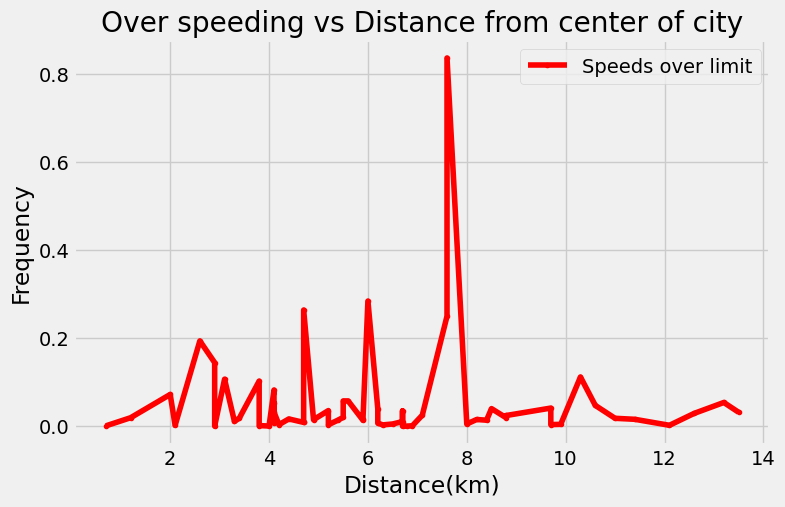

In [521]:
summary2 = summary2.sort_values('DISTANCE')

plt.figure(figsize=(8,5))

plt.plot(summary2.DISTANCE, summary2.C_FREQ_OVER, 'r.-', label="Speeds over limit")

plt.title("Over speeding vs Distance from center of city")
plt.ylabel('Frequency')
plt.xlabel('Distance(km)')
plt.legend()

plt.show()

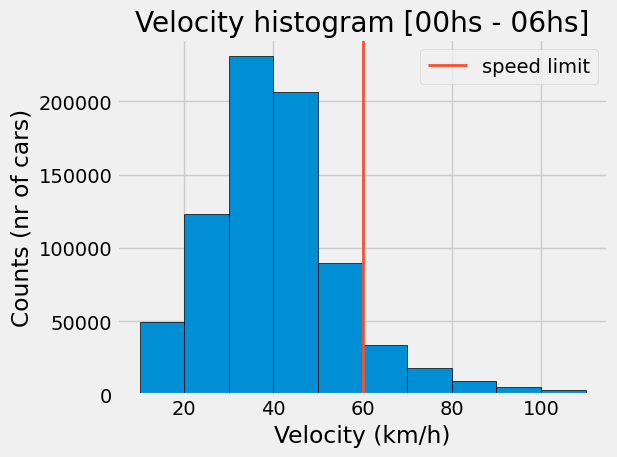

In [522]:
plt.style.use('fivethirtyeight')

bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
plt.hist(vels.loc[vels['DAYTIME'] == 'madrugada']['VELOCITY'], bins=bins, edgecolor='black')

limit = 60
plt.axvline(limit, color=color, label='speed limit', linewidth=2)

plt. legend()
plt.title('Velocity histogram [00hs - 06hs]')
plt.xlabel('Velocity (km/h)')
plt.ylabel('Counts (nr of cars)')
plt.tight_layout()
plt.show()

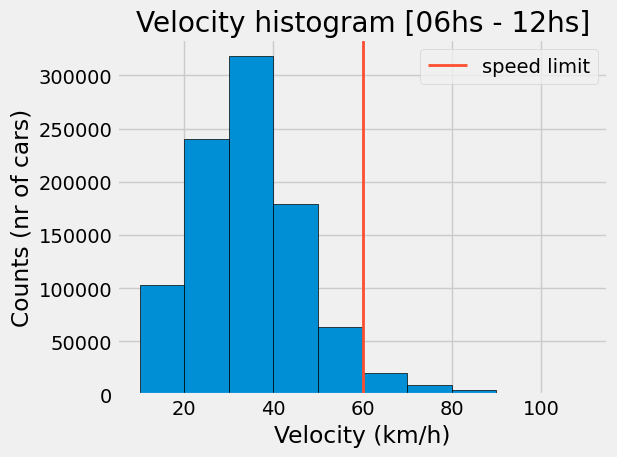

In [523]:
plt.style.use('fivethirtyeight')

bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
plt.hist(vels.loc[vels['DAYTIME'] == 'mañana']['VELOCITY'], bins=bins, edgecolor='black')

limit = 60
plt.axvline(limit, color=color, label='speed limit', linewidth=2)

plt. legend()
plt.title('Velocity histogram [06hs - 12hs]')
plt.xlabel('Velocity (km/h)')
plt.ylabel('Counts (nr of cars)')
plt.tight_layout()
plt.show()

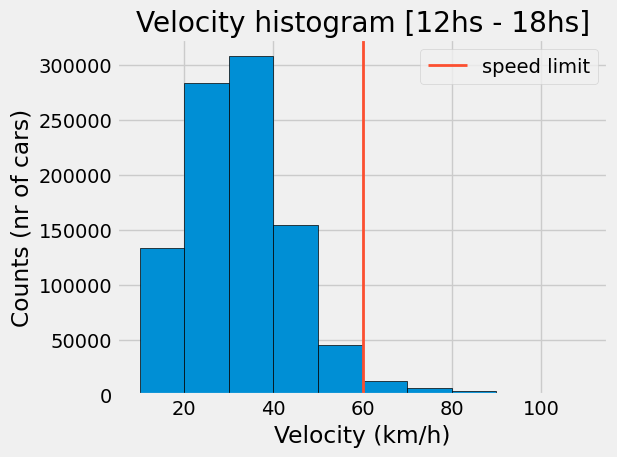

In [524]:
plt.style.use('fivethirtyeight')

bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
plt.hist(vels.loc[vels['DAYTIME'] == 'tarde']['VELOCITY'], bins=bins, edgecolor='black')

limit = 60
plt.axvline(limit, color=color, label='speed limit', linewidth=2)

plt. legend()
plt.title('Velocity histogram [12hs - 18hs]')
plt.xlabel('Velocity (km/h)')
plt.ylabel('Counts (nr of cars)')
plt.tight_layout()
plt.show()

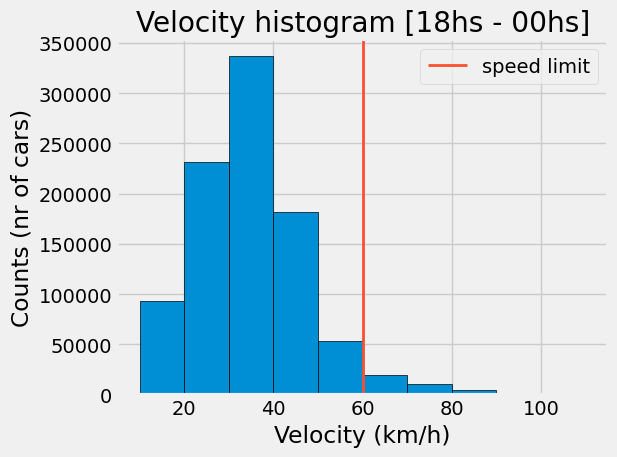

In [525]:
plt.style.use('fivethirtyeight')

bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
plt.hist(vels.loc[vels['DAYTIME'] == 'noche']['VELOCITY'], bins=bins, edgecolor='black')

limit = 60
plt.axvline(limit, color=color, label='speed limit', linewidth=2)

plt. legend()
plt.title('Velocity histogram [18hs - 00hs]')
plt.xlabel('Velocity (km/h)')
plt.ylabel('Counts (nr of cars)')
plt.tight_layout()
plt.show()

In [526]:
summary.iloc[summary['M_FREQ_OVER'].idxmax()]

ClusterLabel       0.00
LAT              -34.87
LON              -56.25
DISTANCE           6.70
MEAN_OVER         68.00
COUNT_OVER         1.00
MEAN_UNDER         9.20
COUNT_UNDER    8,275.00
M_FREQ_OVER        0.88
C_FREQ_OVER        0.00
Name: 33, dtype: float64

In [527]:
max_freq_over_dist = summary.iloc[summary['M_FREQ_OVER'].idxmax()]['DISTANCE']
locations.drop_duplicates(subset='DISTANCE', keep='first', inplace=True)
locations.loc[locations['DISTANCE'] == max_freq_over_dist]

,LAT,LON,DISTANCE,BARRIO
37,-34.85,-56.22,6.70,CARRASCO


In [528]:
vias2 = vias
vias2['DISTANCE'] = vias2.apply(lambda x: distancia(x['LAT'],x['LON']), axis=1)
vias2.DISTANCE = vias2.DISTANCE.round(decimals=1)
vias2.drop_duplicates(subset='DISTANCE', keep='first', inplace=True)

vias2.loc[vias2['DISTANCE'] == max_freq_over_dist]

,LAT,LON,PCODE,CIUDAD,DISTANCE
275040,-34.85,-56.22,11900,MONTEVIDEO,6.70
